In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 
from delta_kernal import *

In [2]:
# SN2020amx
ra = 148.5706917	
dec = 51.68126944
# SN2020fqv
ra = 189.1385827     
dec = 11.2316599
#SN 2020ftl
#ra = 185.0157359	
#dec = 5.343323863


../scenes/syndiff.py:398: RuntimeWarning: invalid value encountered in less
  result = result.iloc[result.tmag.values < magnitude_limit]


417


<IPython.core.display.Javascript object>


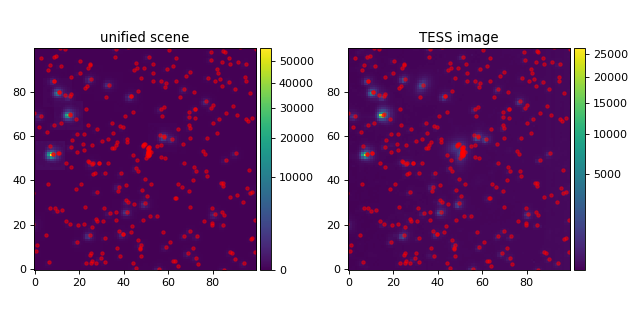

In [3]:
syn= sd.Catalog_scene(ra,dec,100,Maglim= 18, Sector=23, Catalog='unified',Interpolate=False,Plot=True)#,Save='PS1_catalog_scene.pdf')

In [4]:
sources = syn['sources']
tpf = syn['tpf']
cat = syn['catalog']

In [5]:
def Isolated_stars(pos,Tmag,flux,Median,sources, Distance = 7, Mag = 16):
    """
    Find isolated stars in the scene.
    """
    #pos, Tmag = sd.Get_PS1(tpf,magnitude_limit=18)
    pos_shift = pos+.5
    ind = ((Distance//2< pos_shift[:,0]) & (pos_shift[:,0]< flux.shape[1]-Distance//2) & 
          (Distance//2< pos_shift[:,1]) & (pos_shift[:,1]< flux.shape[1]-Distance//2) &
          (Tmag < Mag))
    if ~ind.any():
        raise ValueError('No sources brighter than {} Tmag.'.format(Mag))
    p = pos_shift[ind,:]
    distance= np.zeros([len(p),len(p)])
    for i in range(len(p)):
        distance[i] = np.sqrt((p[i,0] - p[:,0])**2 + (p[i,1] - p[:,1])**2)
    distance[distance==0] = np.nan
    mins = np.nanmin(distance,axis=1)
    iso = p[mins > Distance]
    iso = iso.astype('int')
    iso_s = scene[ind]
    iso_s = iso_s[mins > Distance]
    median = Median
    median[median<0] = 0
    #print(iso)
    if len(iso)> 0:
        clips = []
        time_series = []
        if (Distance % 2) ==0:
            d = Distance - 1
        else:
            d = Distance
        #d = d - 4
        u = d//2 +1 
        l = d //2 
        
        for i in range(len(iso)):
            clips += [[iso_s[i,iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u],
                     median[iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u]]]
            time_series += [flux[:,iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u]]
        #print(clips)
        clips=np.array(clips)
        time_series=np.array(time_series)
    else:
        raise ValueError('No stars brighter than {} Tmag and isolated by {} pix. Concider lowering brightness.'.format(Mag,Distance))
    return iso, clips, time_series

def Isolated_kernals(Sources,Size=5,Scenes = False,Median = True):
    '''
    Calculate the Delta convolution kernals for isolated sources.
    
    -------
    Inputs-
    -------
        Sources  array   n x 2 array of images. 0 is scene, 1 is observation
        Size     int     Size of the delta kernal
    --------
    Options-
    --------
        Scenes   bool  If True, it uses the provided scene as the template
        Median   bool  If True, returns the median of all delta kernals
        
    -------
    Output-
    -------
        Kernals  array  If Median == True, returns single kernal, if not, 
                        returns n kernal array
        
    '''
    kernals = []
    for i in range(len(Sources)):
        star = Sources[i,1]
        if scenes:
            blank = Sources[i,0]
        else:
            blank = np.zeros_like(test)
            blank[blank.shape[0]//2+1,blank.shape[1]//2+1] = np.nansum(test)
        k = Delta_kernal(blank,test,Size=Size,Normalise=False)
        kernals += [k]
    kernals = np.array(kernals)
    if Median:
        return np.nanmedian(kernals,axis=0)
    else:
        return kernals

In [9]:
#cus = np.ones_like(tpf.flux[0])
#cus[20:29,20:29] = 0
#cus[45:55,45:55] = 0
bkg = sd.Scene_bkg_estimate(sources,tpf,Limit=.3)#,Custom_mask=cus)



/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
../scenes/syndiff.py:633: RuntimeWarning: invalid value encountered in less
  large = masked < (med + sigma*std)[:,np.newaxis,np.newaxis]


NameError: name 'bkgs' is not defined

In [10]:
flux = tpf.flux - bkg

<IPython.core.display.Javascript object>


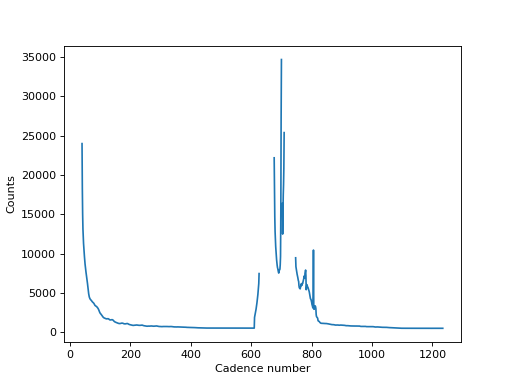

Text(0.5, 0, 'Cadence number')

In [11]:
plt.figure()
lc = np.nansum(bkg[:,50:52,49:51],axis=(1,2))
lc[lc==0] = np.nan
plt.plot(lc)
plt.ylabel('Counts')
plt.xlabel('Cadence number')
#plt.savefig('2020fqv_background.pdf')

In [14]:
f = flux.copy()
f[f<0] = 0
b = bkg.copy()
b[b==0] = np.nan
me = np.nanmedian(b,axis=0)
ind = np.where(np.nansum(b < me,axis=(1,2)) > (b.shape[1]*2))[0]
low_bkg_flux = flux[ind]
low_bkg_flux[low_bkg_flux==0] = np.nan
median = np.nanmedian(low_bkg_flux,axis=0)
pos = np.array([cat.col.values,cat.row.values]).T
Tmag = cat.tmag.values
loc,iso,ts = sd.Isolated_stars(pos,Tmag,f,median,sources,Mag=16,Distance=7)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
../scenes/utils.py:73: RuntimeWarning: invalid value encountered in less
  median[median<0] = 0


<IPython.core.display.Javascript object>


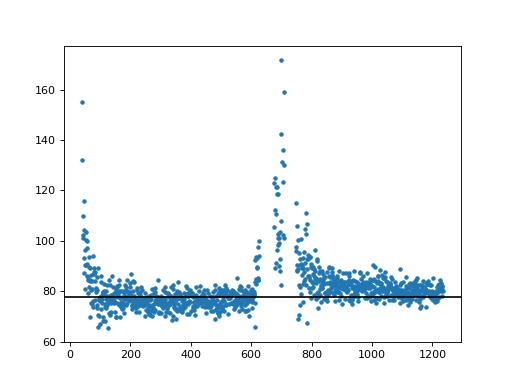

<IPython.core.display.Javascript object>


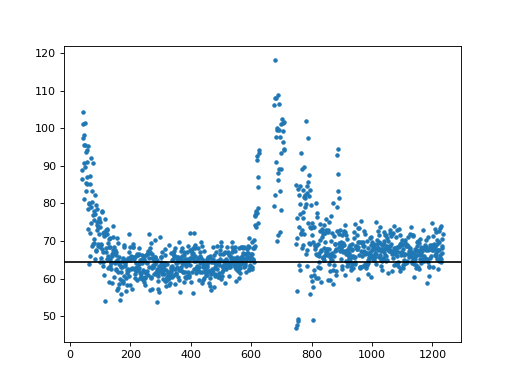

<IPython.core.display.Javascript object>


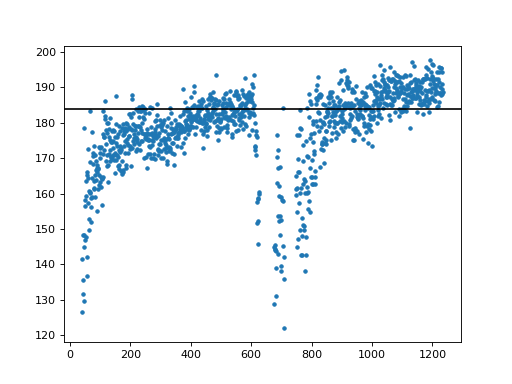

<IPython.core.display.Javascript object>


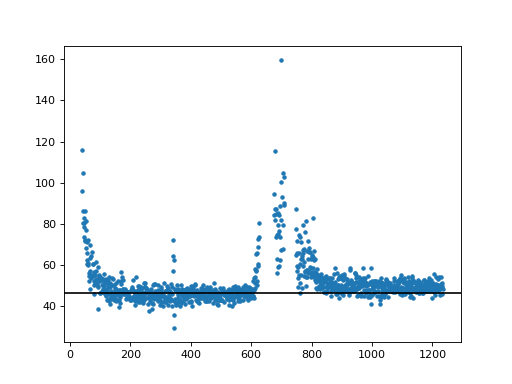

<IPython.core.display.Javascript object>


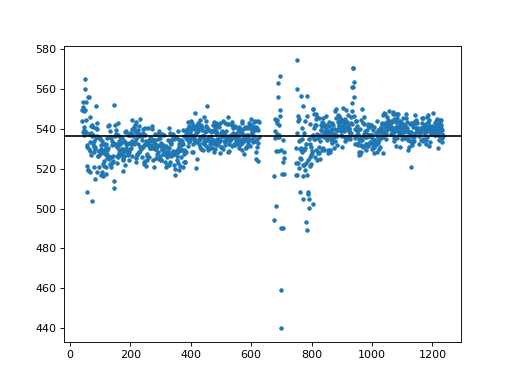

<IPython.core.display.Javascript object>


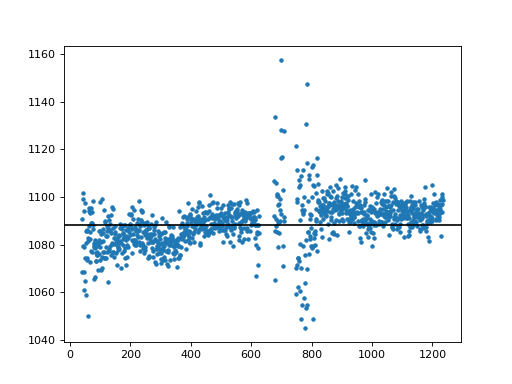

<IPython.core.display.Javascript object>


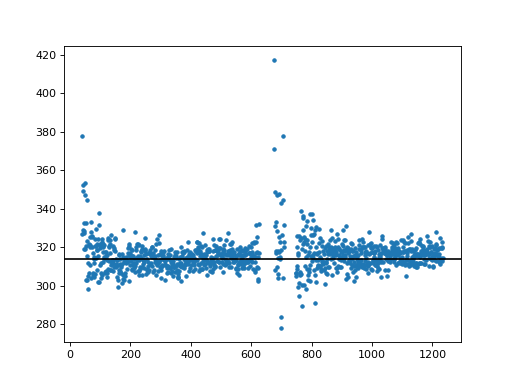

<IPython.core.display.Javascript object>


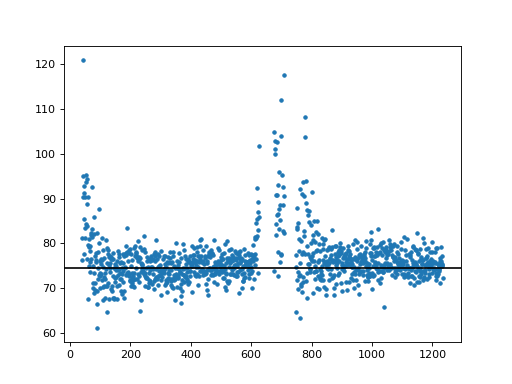

<IPython.core.display.Javascript object>


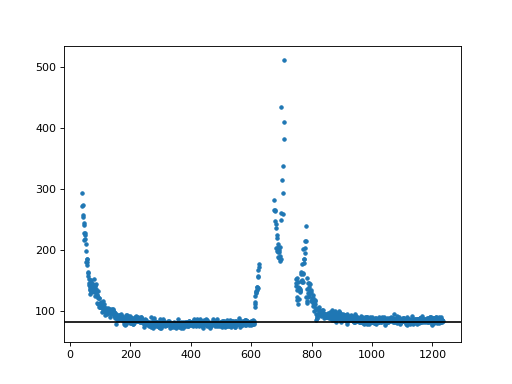

<IPython.core.display.Javascript object>


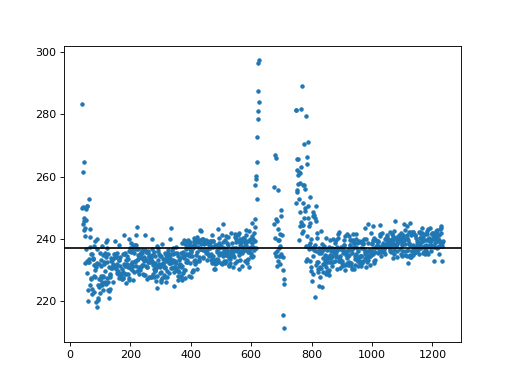

<IPython.core.display.Javascript object>


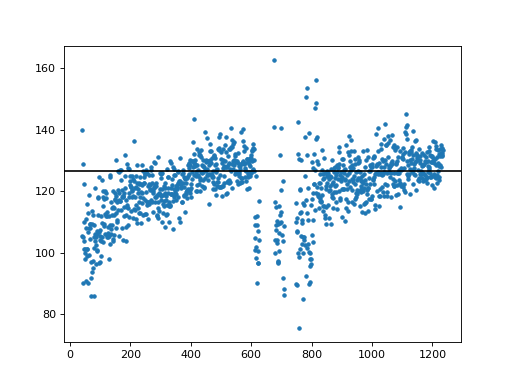

<IPython.core.display.Javascript object>


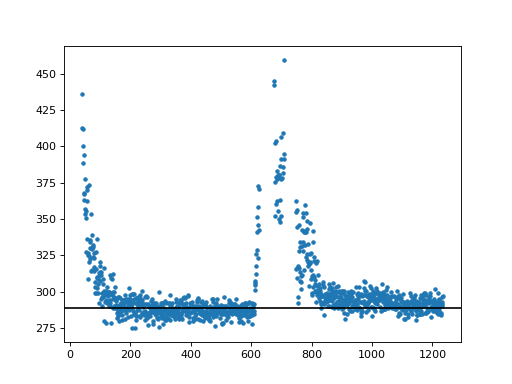

<IPython.core.display.Javascript object>


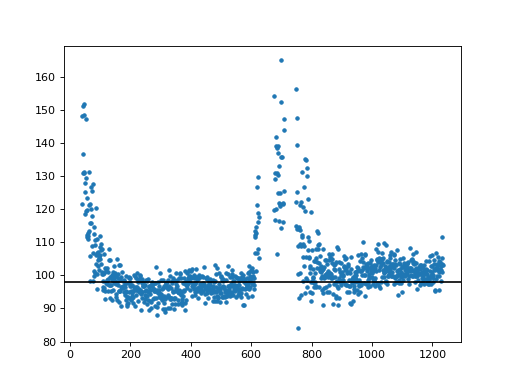

<IPython.core.display.Javascript object>


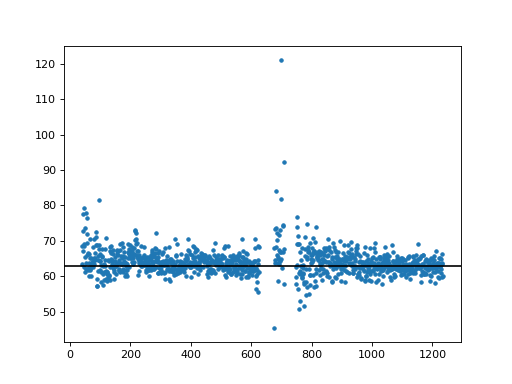

<IPython.core.display.Javascript object>


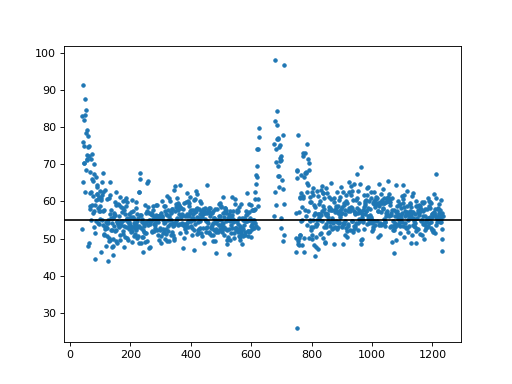

<IPython.core.display.Javascript object>


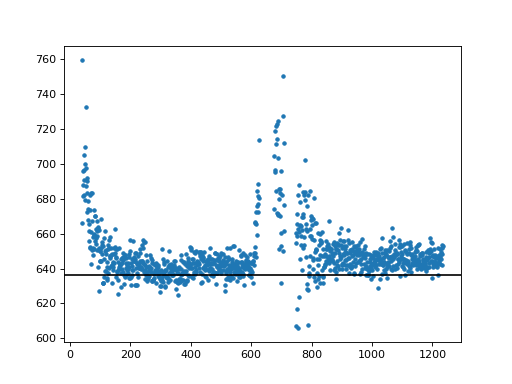

<IPython.core.display.Javascript object>


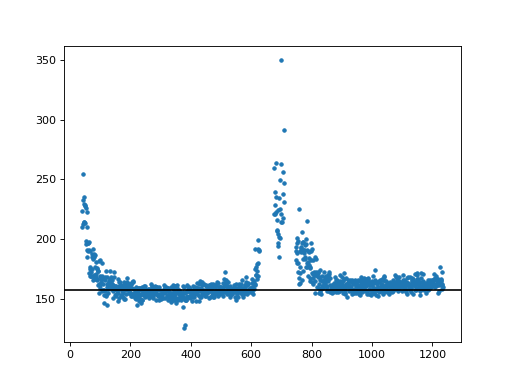

<IPython.core.display.Javascript object>


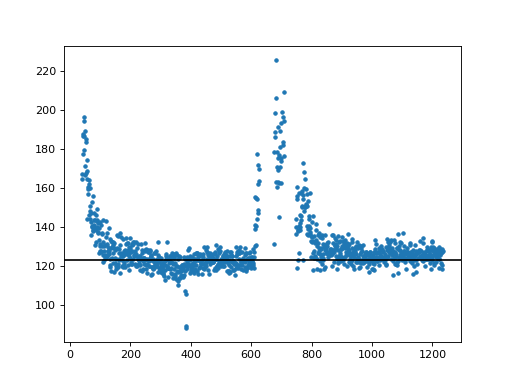

<IPython.core.display.Javascript object>


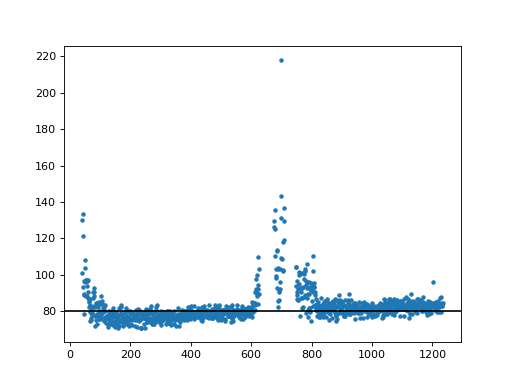

<IPython.core.display.Javascript object>


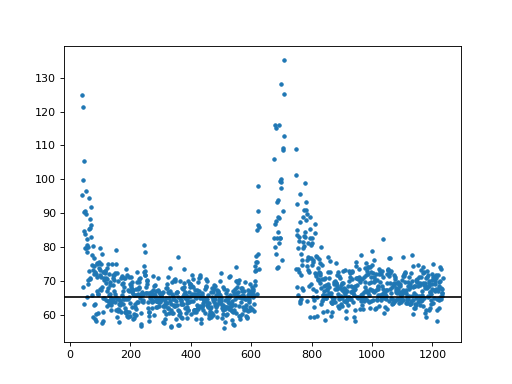

<IPython.core.display.Javascript object>


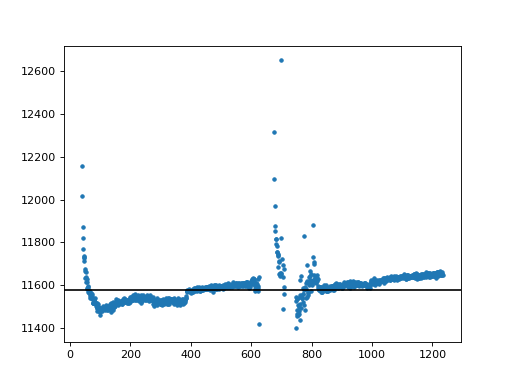

<IPython.core.display.Javascript object>


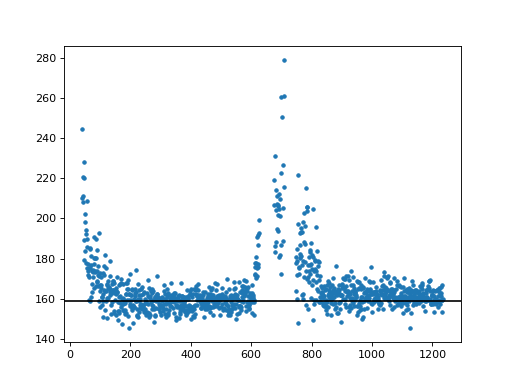

<IPython.core.display.Javascript object>


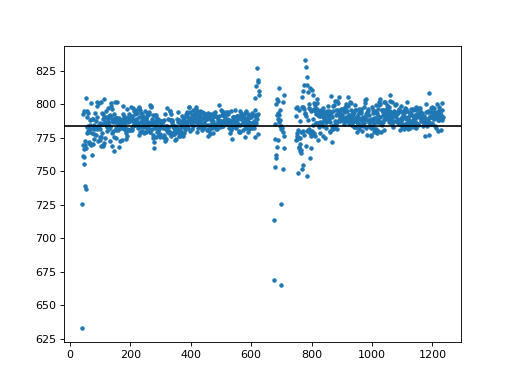

In [174]:
for h in range(len(iso)):
    plt.figure()
    lc = np.nansum(ts[h],axis=(1,2))
    lc[lc==0] = np.nan
    plt.plot(lc,'.')
    plt.axhline(np.nansum(iso[h,1],axis=(0,1)),c='k')
    #plt.plot(f[:,34,34],'.')

<IPython.core.display.Javascript object>


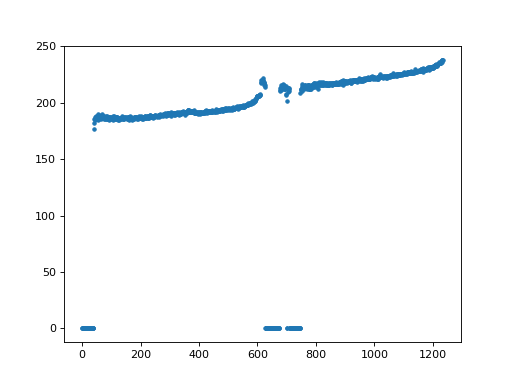

In [56]:
plt.figure()
plt.plot(f[:,35,34],'.')

In [7]:
def Time_series_kernal(data,reference,Flat = True,Size = 5,Median=True):
    kernals = np.zeros((len(reference),data.shape[1],Size,Size))
    for i in range(len(reference)):
        print('reference '+ str(i))
        star = reference[i]
        star[np.isnan(star)] = 0
        for j in range(data.shape[1]):
            if np.nansum(data[i,j]) >0:
                if Flat:
                    diff = np.nansum(np.nansum(data[i,j]) - np.nansum(star))
                    frame = data[i,j] - (diff / (star.shape[0]*star.shape[1]))
                else:
                    frame = data[i,j]
                
                k = Delta_kernal(star,frame,Size=Size,Normalise=False)
                kernals[i,j] = k

    if Median:
        return np.nanmedian(kernals,axis=0)
    else:
        return kernals

In [31]:
ks = Time_series_kernal(ts[:2],iso[:2,1],Median=True)

reference 0
reference 1


<IPython.core.display.Javascript object>


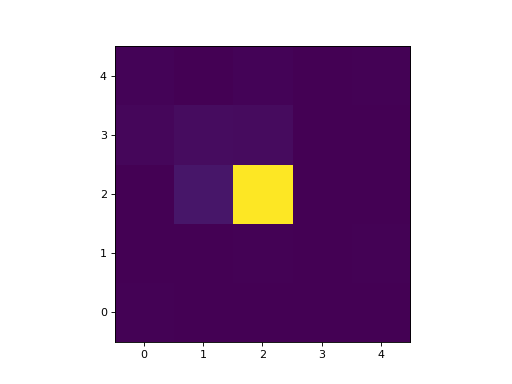

In [34]:
plt.figure()
plt.imshow(ks[100],origin='')

In [36]:
np.save('test_kernals.py',ks)

In [38]:
thing = f.copy()
for i in range(len(thing)):
    thing[i] = sd.signal.fftconvolve(thing[i], ks[i], mode='same')

In [47]:
tt = thing - f

In [48]:
np.nansum(tt)

-791048.25

<IPython.core.display.Javascript object>


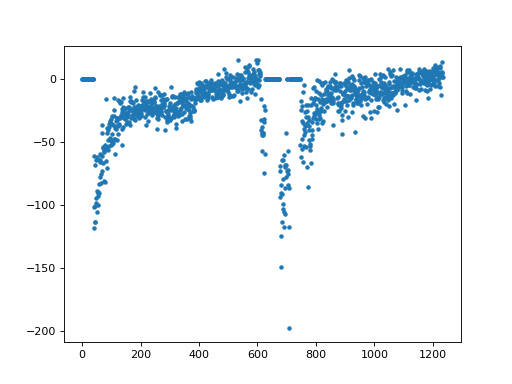

In [52]:
plt.figure()
plt.plot(tt[:,36,36],'.')

In [ ]:
from joblib import Parallel

In [27]:
Flat = True
star = iso[0,1]
star[np.isnan(star)] = 0 
data = ts
if Flat:
    diff = np.nansum(np.nansum(data[0,100]) - np.nansum(star))
    frame = data[0,100] - diff / (star.shape[0]*star.shape[1])
else:
    frame = data[i,j]

k = Delta_kernal(star,frame,Size=5,Normalise=False)

<IPython.core.display.Javascript object>


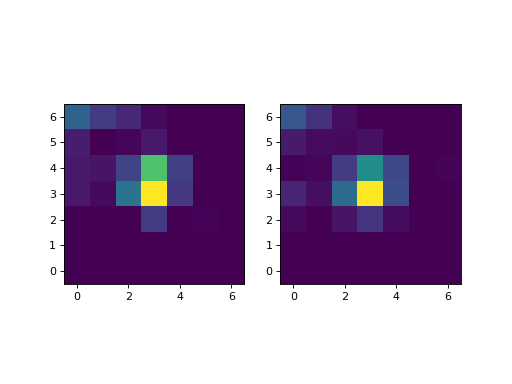

In [28]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(frame,origin='')
plt.subplot(1,2,2)
plt.imshow(star,origin='')

<IPython.core.display.Javascript object>


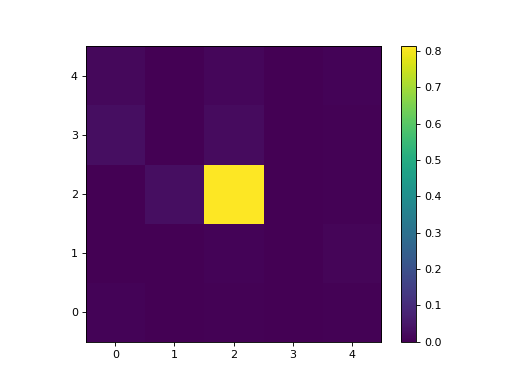

In [29]:
plt.figure()

plt.imshow(k,origin='')
plt.colorbar()

In [53]:
thing = bkg[:,10,10]
thing[thing == 0 ] =np.nan

<IPython.core.display.Javascript object>


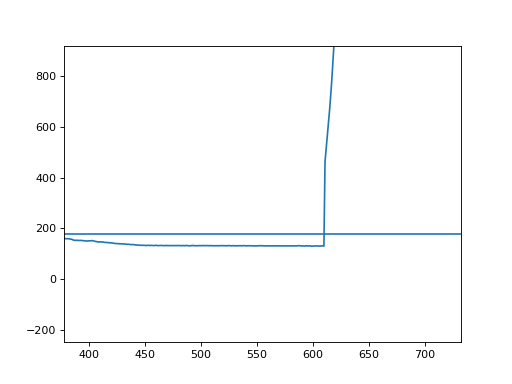

In [57]:
plt.figure()
plt.plot(thing)
plt.axhline(np.nanmedian(thing))

In [58]:
ind = np.nanmedian(thing)

178.58171

In [59]:
b = bkg.copy()
b[b==0] = np.nan
me = np.nanmedian(b,axis=0)

In [66]:
ind = np.where(np.nansum(b < me,axis=(1,2)) > 0)[0]
low_bkg_flux = flux[ind]

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [68]:
l = np.nanmedian(flux[ind],axis=0)
ls = np.nanstd(flux[ind],axis=0)

In [69]:
f = np.nanmedian(flux,axis=0)
fs = np.nanstd(flux,axis=0)

<IPython.core.display.Javascript object>


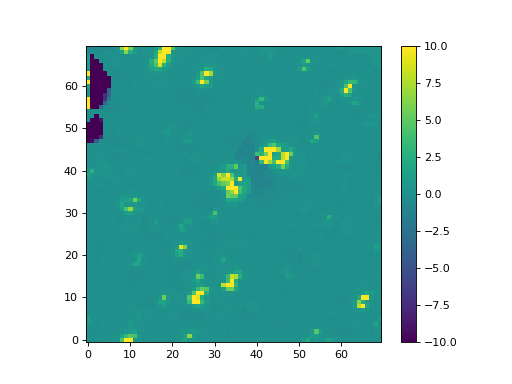

<IPython.core.display.Javascript object>


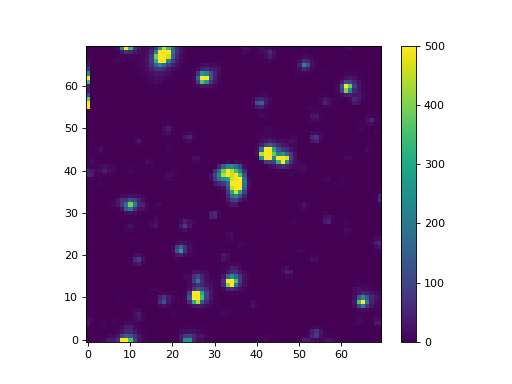

In [84]:
plt.figure()
plt.imshow(l-f,origin='',vmin=-10,vmax=10)
plt.colorbar()
plt.figure()
plt.imshow(f,origin='',vmin=0,vmax=500)
plt.colorbar()

# Test centroids

In [16]:
from photutils import centroid_com, centroid_1dg, centroid_2dg

In [16]:
ts.shape

(7, 1235, 7, 7)

In [118]:
cent = []
u = ts[1]
for i in range(len(u)):
    c = centroid_com(u[i])
    cent += [c]
    
cent = np.array(cent)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/photutils/centroids/core.py:132: RuntimeWarning: invalid value encountered in double_scalars
  for axis in range(data.ndim)])[::-1]


In [119]:
ref = centroid_com(iso[1,1])

In [26]:
False + True

1

In [17]:
def Centroids(Stars,References,Trim=0,Plot=False):
    """
    Calculate the centroid offsets for a set of reference stars.
    """
    flags = np.zeros((Stars.shape[0]))
    centroids = np.zeros((Stars.shape[0],Stars.shape[1],2))
    for i in range(len(Stars)):
        star = Stars[i]
        lc = np.nansum(star,axis=(1,2))
        lc[lc==0] = np.nan
        med = lc/np.nanmedian(lc)
        fixed = np.nanmedian(lc) + 100
        bads = np.nansum((med>1.2) | (lc > fixed))
        if bads >= 10:
            flags[i] = 1
        for j in range(len(star)):
            if Trim == 0:
                c = centroid_com(star[j])
                ref = centroid_com(References[i])
            else:
                c = centroid_com(star[j,Trim:-Trim,Trim:-Trim])
                ref = centroid_com(References[i,Trim:-Trim,Trim:-Trim])
            c = c - ref
            centroids[i,j] = c
        if Plot:
            Plot_centroids(centroids[i],star,i)
    centroids[np.isnan(centroids)] = 0
    return centroids, flags

def Plot_centroids(Centoids,Star,Num,Save=False):
    x = np.arange(0,len(Centoids))
    plt.figure()
    plt.subplot(221)
    plt.scatter(x,Centoids[:,0],marker='.',c=x,alpha = 1)
    #plt.ylim(-.4,.4)
    plt.ylabel('$\Delta$Column')
    plt.xlabel('Frame')
    plt.subplot(222)
    plt.scatter(x,Centoids[:,1],marker='.',c=x,alpha = 1)
    plt.ylabel('$\Delta$Row')
    plt.xlabel('Frame')
    #plt.ylim(-.4,.4)
    plt.subplot(223)
    im = plt.scatter(Centoids[:,0],Centoids[:,1],marker='.',c=x,alpha = 1)
    plt.ylabel('$\Delta$Row')
    plt.xlabel('$\Delta$Column')
    plt.subplot(224)
    lc = np.nansum(Star,axis=(1,2))
    lc[lc==0] = np.nan
    med = lc/np.nanmedian(lc)
    fixed = np.nanmedian(lc) + 100
    bads = np.nansum((med>1.2) | (lc > fixed))
    if bads >= 10:
        plt.plot(lc,'r-')
    else:
        plt.plot(lc,'g-')
    #plt.axhline(np.nanmedian(lc),ls='--',c='k')
    plt.ylabel('Counts')
    plt.xlabel('Frame (Bad frames = {})'.format(bads) )
    plt.suptitle('Reference star {}'.format(Num))
    plt.subplots_adjust(wspace=.35,hspace=.4)
    
    if Save:
        plt.savefig('./Centroids_Star_{}.pdf'.format(Num))
    #plt.tight_layout()


/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Users/ryanr/miniconda3/lib/python3.7/site-packages/photutils/centroids/core.py:132: RuntimeWarning: invalid value encountered in double_scalars
  for axis in range(data.ndim)])[::-1]


<IPython.core.display.Javascript object>


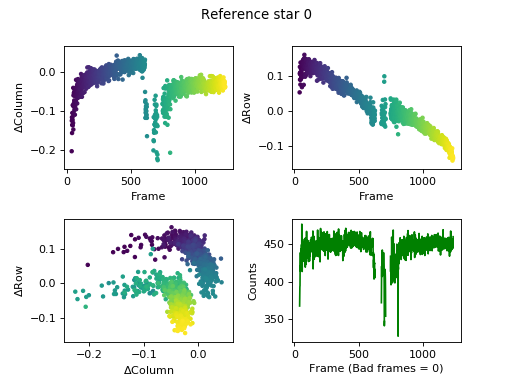

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


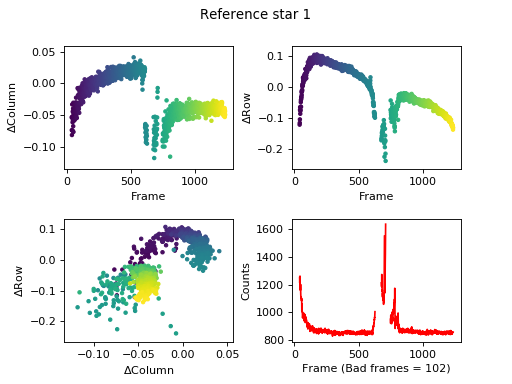

<IPython.core.display.Javascript object>


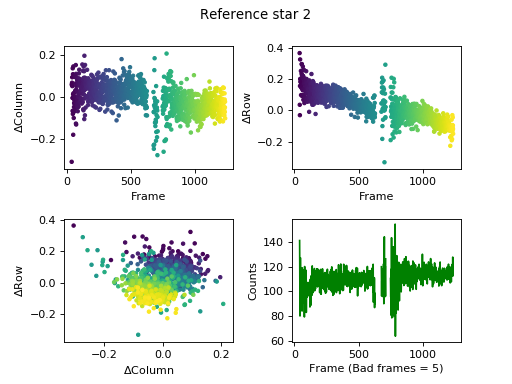

<IPython.core.display.Javascript object>


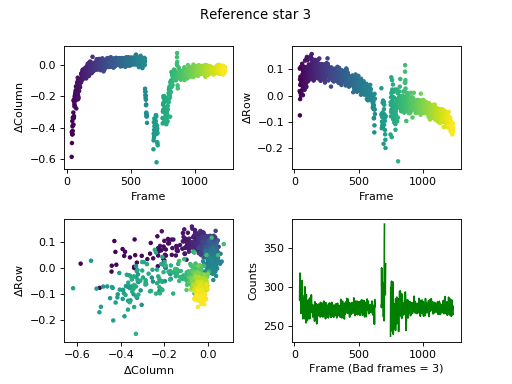

<IPython.core.display.Javascript object>


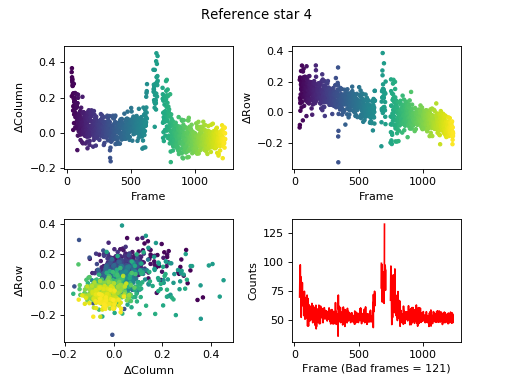

<IPython.core.display.Javascript object>


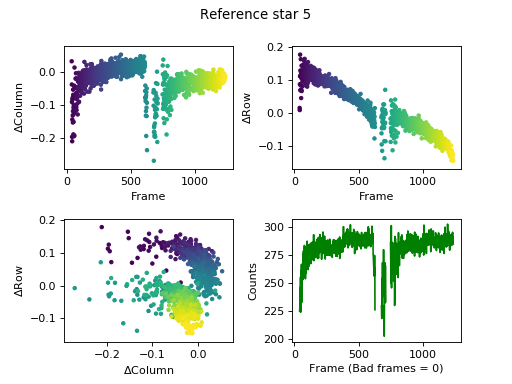

<IPython.core.display.Javascript object>


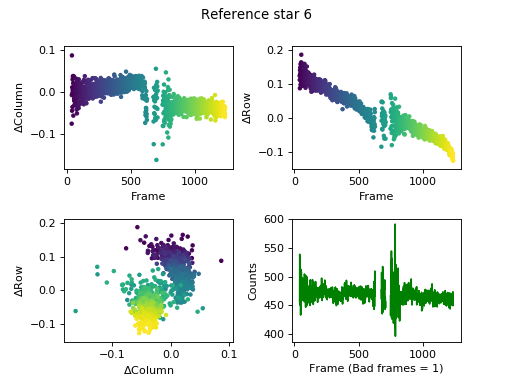

<IPython.core.display.Javascript object>


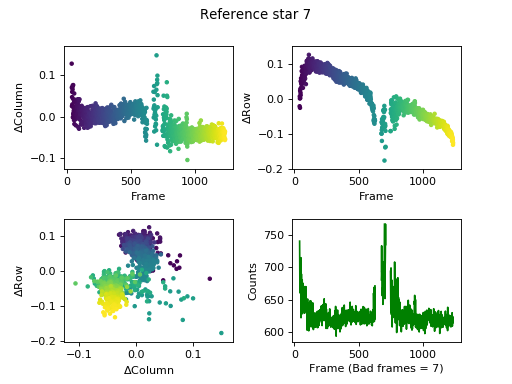

<IPython.core.display.Javascript object>


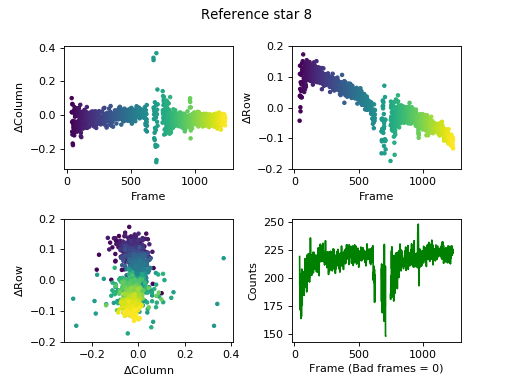

<IPython.core.display.Javascript object>


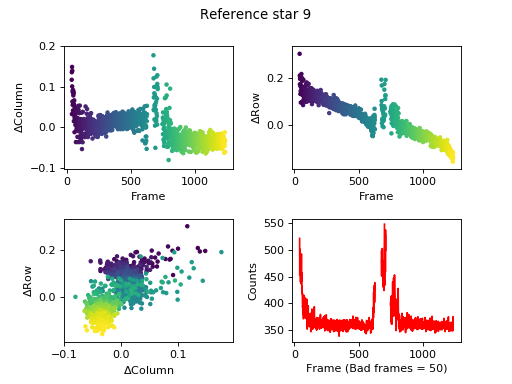

<IPython.core.display.Javascript object>


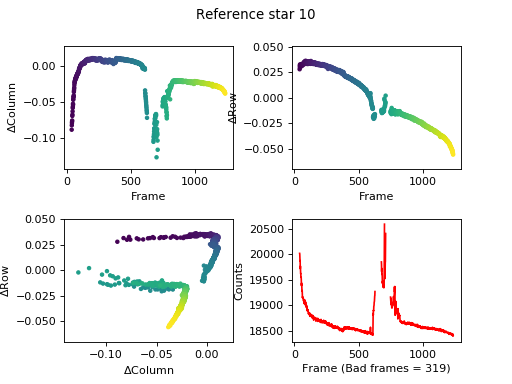

<IPython.core.display.Javascript object>


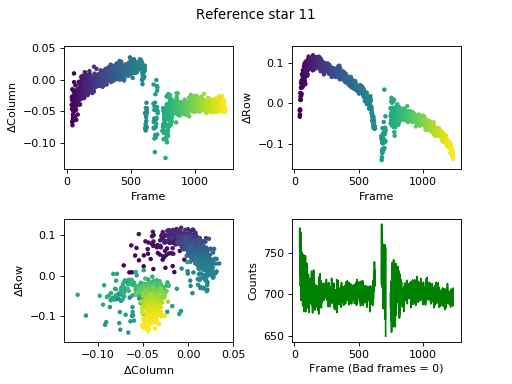

<IPython.core.display.Javascript object>


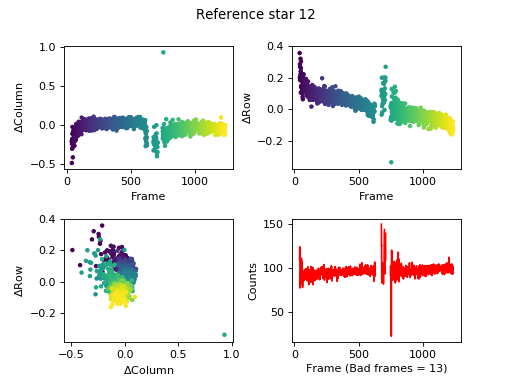

<IPython.core.display.Javascript object>


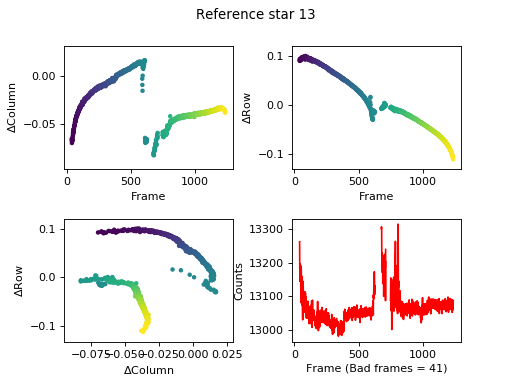

<IPython.core.display.Javascript object>


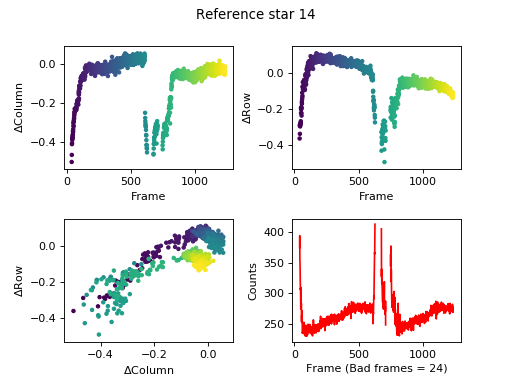

<IPython.core.display.Javascript object>


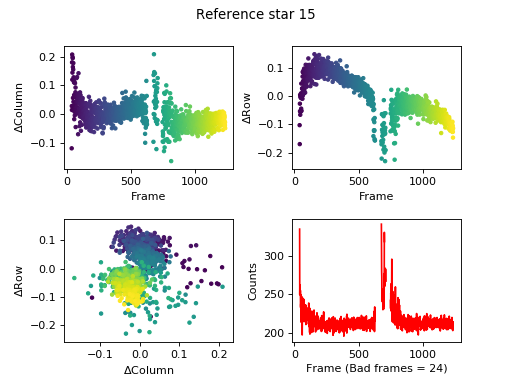

<IPython.core.display.Javascript object>


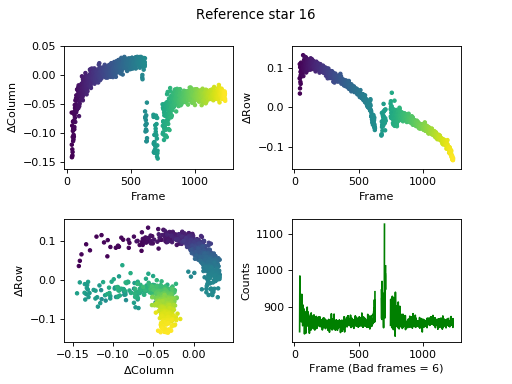

<IPython.core.display.Javascript object>


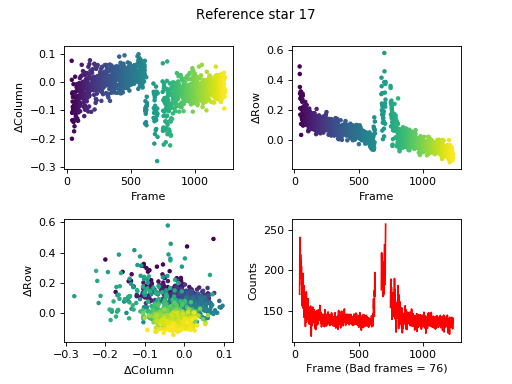

/Users/ryanr/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


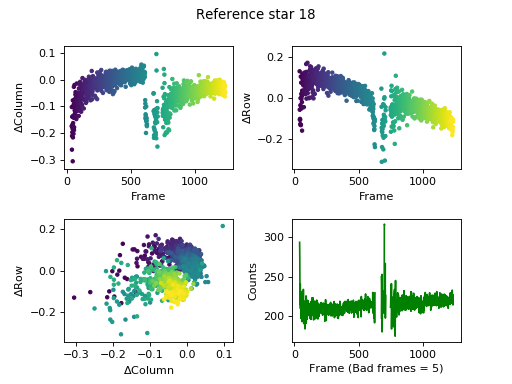

<IPython.core.display.Javascript object>


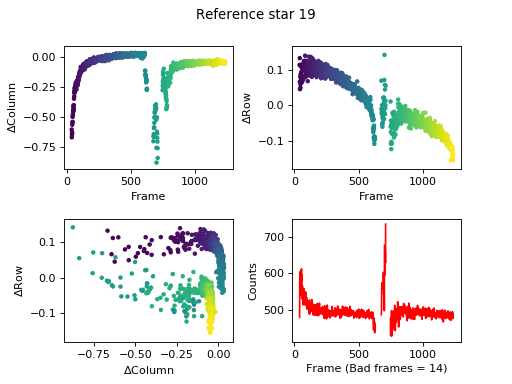

<IPython.core.display.Javascript object>


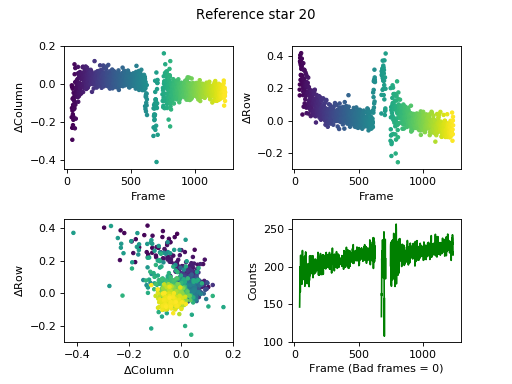

In [20]:
loc,iso,ts = sd.Isolated_stars(pos,Tmag,f,median,sources,Mag=16,Distance=7)
c, flag = Centroids(ts,iso[:,1],1,True)
medc = np.nanmedian(c,axis=0)

In [323]:
ts

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        

In [21]:
medc = np.nanmedian(c[flag==0],axis=0)

In [30]:
medc = np.nanmedian(c,axis=0)

In [35]:
medc

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [-0.0497585 , -0.12545472],
       [-0.04373448, -0.11989559],
       [-0.04106221, -0.12511659]])

<IPython.core.display.Javascript object>


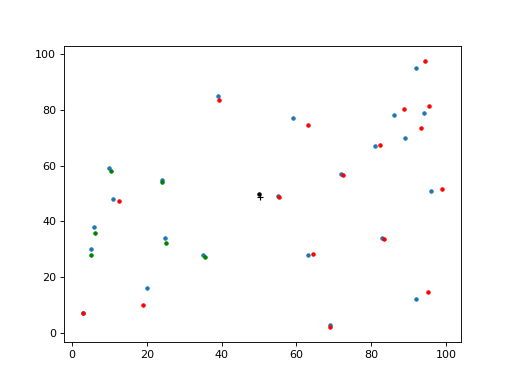

In [327]:
plt.figure()
plt.scatter(loc[:,1],loc[:,0],marker='.')
plt.scatter(c[flag==0,45,1]*5+loc[flag==0,1],c[flag==0,45,0]*5+loc[flag==0,0],marker='.',c='g')
plt.scatter(c[flag==1,45,1]*5+loc[flag==1,1],c[flag==1,45,0]*5+loc[flag==1,0],marker='.',c='r')
plt.plot(50,50,'k.')
plt.plot(50+medc[45,1]*5,50+medc[45,0]*5,'k+')

In [22]:
from scipy.signal import savgol_filter

In [70]:
medc.shape

(1235, 2)

In [113]:
smoothx = savgol_filter(medc[~naninds,0], 51, 3)

In [126]:
np.where(alllc==0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638,
        639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651,
        652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664,
        665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 701, 702,
        710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722,
        723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735,
        736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746]),)

In [125]:
alllc = np.nansum(f,axis=(1,2))
naninds = naninds == 0
test = medc[:,0].copy()
test[naninds] = np.nan

In [98]:
naninds

array([ True,  True,  True, ..., False, False, False])

In [96]:
np.nansum(f,axis=(1,2))

array([     0.  ,      0.  ,      0.  , ..., 340103.75, 340164.2 ,
       340140.9 ], dtype=float32)

In [119]:
14

TypeError: object of type 'int' has no len()

In [108]:
thing = smoothx.copy()
thing[naninds]=np.nan

In [118]:
len(medc[~naninds,0])

1107

In [133]:
split = np.where(np.diff(tpf.astropy_time.mjd) > 1)[0][0] + 1

In [23]:
def Smooth_motion(Centroids,tpf):
    split = np.where(np.diff(tpf.astropy_time.mjd) > 1)[0][0] + 1
    smoothed = np.zeros_like(Centroids) * np.nan
    # ugly, but who cares
    ind1 = np.nansum(tpf.flux[:split],axis=(1,2))
    ind1 = np.where(ind1 != 0)[0]
    ind2 = np.nansum(tpf.flux[split:],axis=(1,2))
    ind2 = np.where(ind2 != 0)[0] + split
    smoothed[ind1,0] = savgol_filter(Centroids[ind1,0],51,3)
    smoothed[ind2,0] = savgol_filter(Centroids[ind2,0],51,3)

    smoothed[ind1,1] = savgol_filter(Centroids[ind1,1],51,3)
    smoothed[ind2,1] = savgol_filter(Centroids[ind2,1],51,3)
    return smoothed
    

In [24]:
smooth = Smooth_motion(medc,tpf)

In [63]:
medc[~naninds,:] = np.nan

NameError: name 'naninds' is not defined

<IPython.core.display.Javascript object>


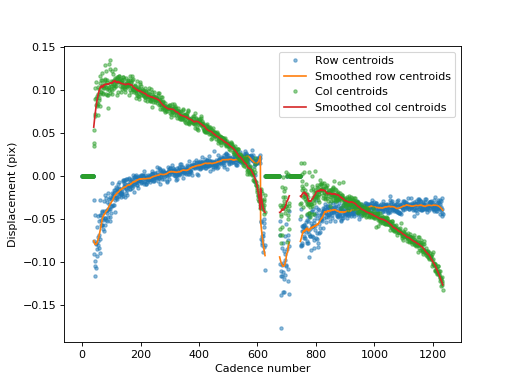

In [25]:
plt.figure()
plt.plot(medc[:,0],'.',label='Row centroids',alpha =0.5)
plt.plot(smooth[:,0],'-',label='Smoothed row centroids')
plt.plot(medc[:,1],'.',label='Col centroids',alpha =0.5)
plt.plot(smooth[:,1],'-',label='Smoothed col centroids')
#plt.plot(thing,'+')
plt.ylabel('Displacement (pix)')
plt.xlabel('Cadence number')
plt.legend()
#plt.savefig('2020fqv_motion.pdf')

<IPython.core.display.Javascript object>


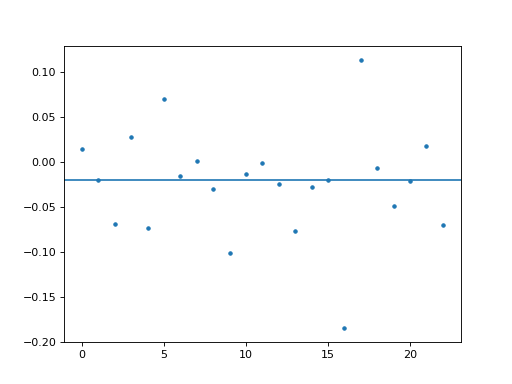

In [91]:
plt.figure()
plt.plot(c[:,111,0],'.')
plt.axhline(np.nanmedian(c[:,111,0]))

In [ ]:
loc,iso,ts = Isolated_stars(pos,Tmag,mmm,median,scene,Mag=16,Distance=7)
def Sub_residual():
    

# How does shift act

In [26]:
def Shift_images(Offset,Data):
    """
    Shifts data by the values given in offset. Breaks horribly if data is all 0.

    """
    shifted = Data.copy()
    data = Data.copy()
    #data[data<0] = 0
    for i in range(len(data)):
        if np.nansum(data[i]) > 0:
            shifted[i] = sd.shift(data[i],[-Offset[i,1],-Offset[i,0]],mode='nearest',order=3)
    return shifted

def Shift_median(Offset,Med):
    """
    Shifts data by the values given in offset. Breaks horribly if data is all 0.

    """
    Offset[np.isnan(Offset)] = 0
    shifted = np.zeros((len(Offset),Med.shape[0],Med.shape[1]))
    Med[np.isnan(Med)] = 0
    Med[Med<0] = 0
    for i in range(len(Offset)):
        shifted[i] = sd.shift(Med,[Offset[i,1],Offset[i,0]],mode='nearest',order=3)

    return shifted

<IPython.core.display.Javascript object>


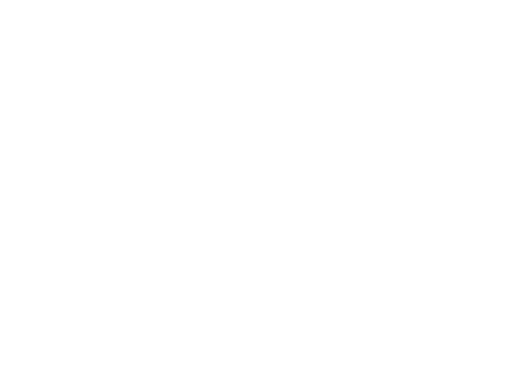

NameError: name 'mm' is not defined

In [15]:
m = median.copy()
m[np.isnan(m)] = 0
plt.figure()
plt.imshow(m-mm,origin='',vmin=-100,vmax=100)
plt.colorbar()

In [72]:
medc[np.isnan(medc)] = 0

In [68]:
mm = sd.shift(m,[0,0],mode='nearest',order=3)

In [73]:
[medc[100,1],medc[100,0]]

[0.0949251004240057, -0.03447165565942778]

In [49]:
m = median.copy()
stest = Shift_median(smooth,m)

mmm = f- stest
mmm_s = Shift_images(smooth,mmm)
mmm[f==0] = np.nan
mmm_s[f==0] = np.nan
ff= f.copy()
ff[f==0] = np.nan
ff = ff -median

In [53]:
lc = np.nansum(mmm[:,50:52,49:51]+50,axis=(1,2))
lc_s = np.nanmedian(mmm_s[:,50:52,48]+50,axis=(1))
lc[lc==0] = np.nan
lc_s[lc_s==0] = np.nan

med = np.nanmedian(lc[:500])
med_s = np.nanmedian(lc_s[:500])

eh = np.nansum(ff[:,50:52,49:51]+50,axis=(1,2))
eh[eh==0] = np.nan
med_e = np.nanmedian(eh[:500])

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


<IPython.core.display.Javascript object>


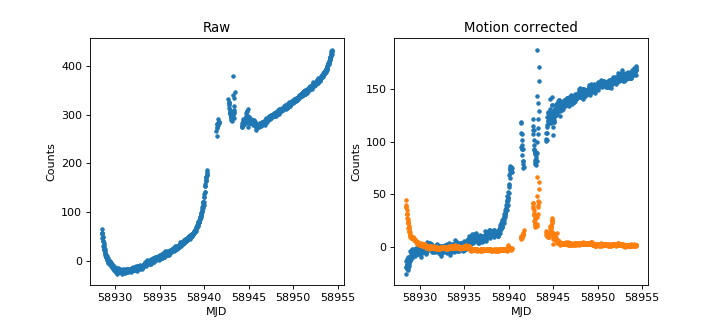

Text(0.5, 0, 'MJD')

In [59]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title('Raw')
plt.plot(tpf.astropy_time.mjd,eh-med_e,'.')
plt.ylabel('Counts')
plt.xlabel('MJD')
plt.subplot(1,2,2)
plt.title('Motion corrected')
plt.plot(tpf.astropy_time.mjd,lc-med,'.',label='Motion corrected')
plt.plot(tpf.astropy_time.mjd,lc_s-med_s,'.',label='Shift reference & difference')

#plt.ylim(-20,90)
#plt.legend()
plt.ylabel('Counts')
plt.xlabel('MJD')
#plt.savefig('2020fqv_lc_motion.pdf')

In [ ]:
plt.plot(tpf.astropy_time.mjd,-2.5*np.log10(lc_s-49)+20.44,'.')

<IPython.core.display.Javascript object>


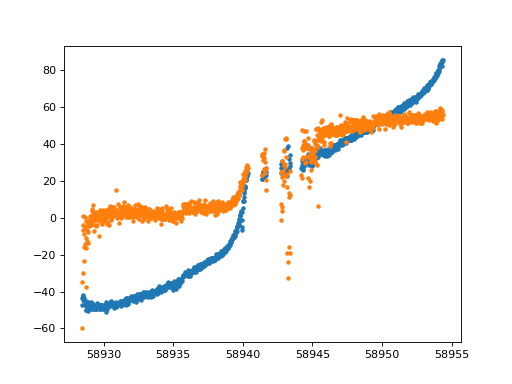

In [212]:
plt.figure()
plt.plot(tpf.astropy_time.mjd,ff[:,50,50],'.')
plt.plot(tpf.astropy_time.mjd,mmm[:,50,50]+15,'.')
#plt.plot(tpf.astropy_time.mjd,-2.5*np.log10(lc-40)+20.44,'.')
#plt.ylim(20,15)

In [60]:
np.save('2020fqv_shift_better_bkg',[tpf.astropy_time.mjd,lc-med])

<IPython.core.display.Javascript object>


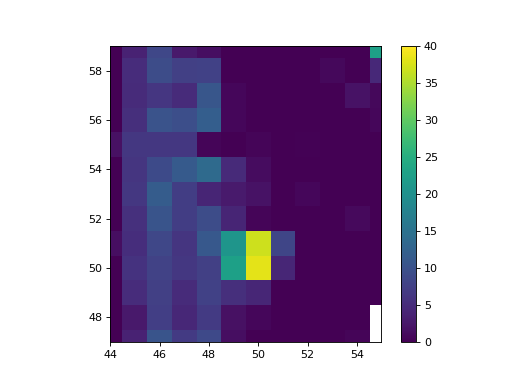

In [62]:
plt.figure()
plt.imshow(mmm[800]-mmm[400],vmin=0,vmax=40,origin='')
plt.colorbar()
plt.xlim(44,55)
plt.ylim(47,59)
plt.savefig('2020fqv_difference.pdf')

In [227]:
shifted = Shift_images(medc,flux)

kernals

In [130]:
ks = np.load('test_kernals.py.npy')

In [131]:
test = shifted.copy()
test[np.isnan(test)] = 0
for i in range(len(test)):
    test[i] = sd.signal.fftconvolve(test[i], ks[i], mode='same')

In [228]:
f[f==0] = np.nan
s = shifted.copy()
s[s==0] = np.nan

<IPython.core.display.Javascript object>


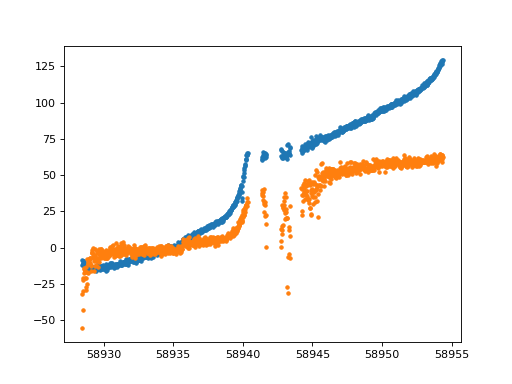

In [234]:
a = s - np.nanmedian(s[100:600],axis=0)
lc = np.nansum(a[:,49:52,49:52],axis=(1,2))
lc = a[:,50,50]
lc[lc==0] = np.nan
ar = f - np.nanmedian(f[100:600],axis=0)
lcr = np.nansum(ar[:,49:52,49:52],axis=(1,2))
lcr = ar[:,50,50]
lcr[lcr==0] = np.nan
plt.figure()
plt.plot(tpf.astropy_time.mjd,lcr,'.')
plt.plot(tpf.astropy_time.mjd,lc,'.')

#plt.ylim(0,200)
#plt.xlim(58933,58950)

In [203]:
plt.figure()
plt.imshow(s[800]-s[400],vmin=0,vmax=40,origin='')
plt.colorbar()
plt.xlim(40,55)
plt.ylim(47,59)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

NameError: name 's' is not defined

In [198]:
loc = []

In [239]:
loc,iso,ts = Isolated_stars(pos,Tmag,mmm,median,scene,Mag=16,Distance=7)
#locs,isos,tss = Isolated_stars(pos,Tmag,f-median,median,scene,Mag=16,Distance=7)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


In [159]:
iso.shape

(18, 2, 7, 7)

<IPython.core.display.Javascript object>


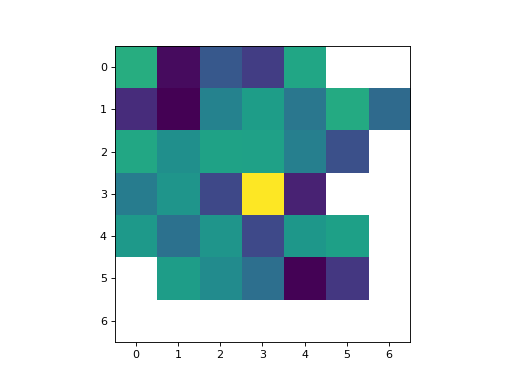

In [111]:
plt.figure()
plt.imshow(ts[1,100])

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


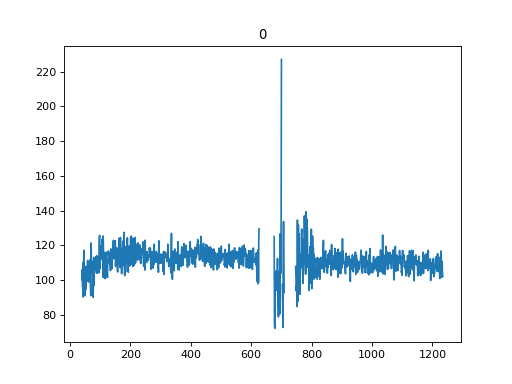

<IPython.core.display.Javascript object>


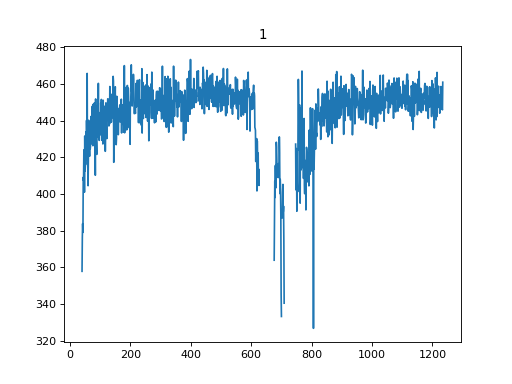

<IPython.core.display.Javascript object>


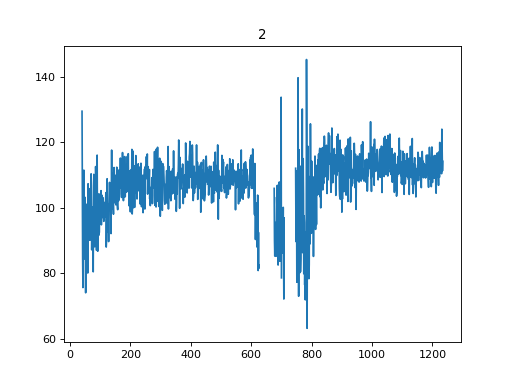

<IPython.core.display.Javascript object>


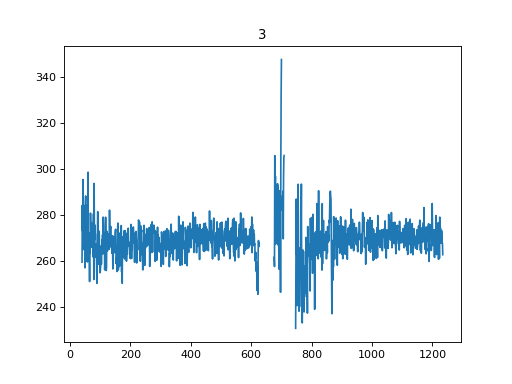

<IPython.core.display.Javascript object>


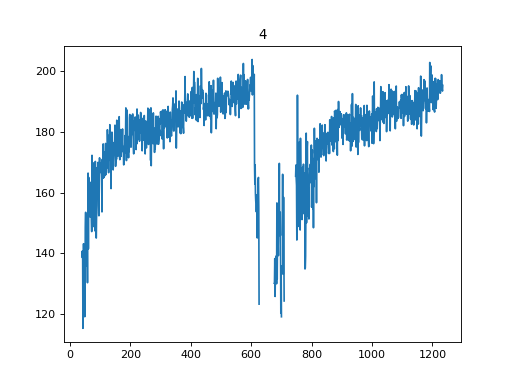

<IPython.core.display.Javascript object>


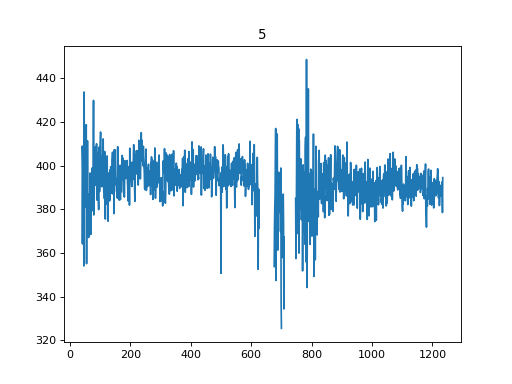

<IPython.core.display.Javascript object>


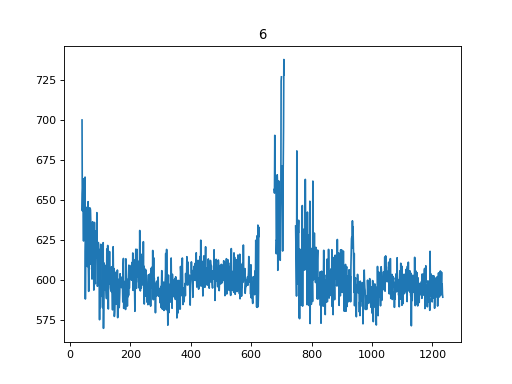

<IPython.core.display.Javascript object>


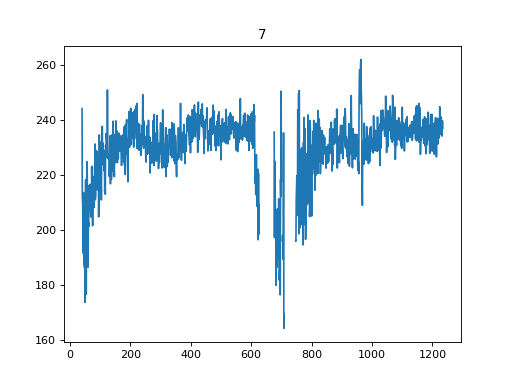

<IPython.core.display.Javascript object>


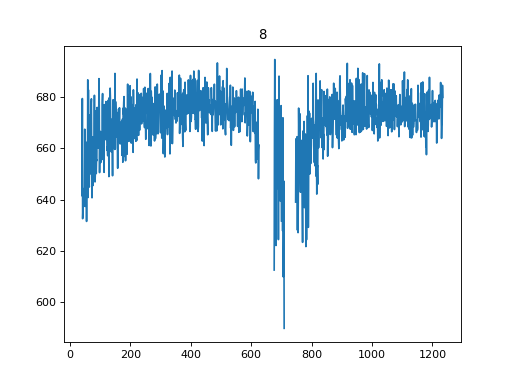

<IPython.core.display.Javascript object>


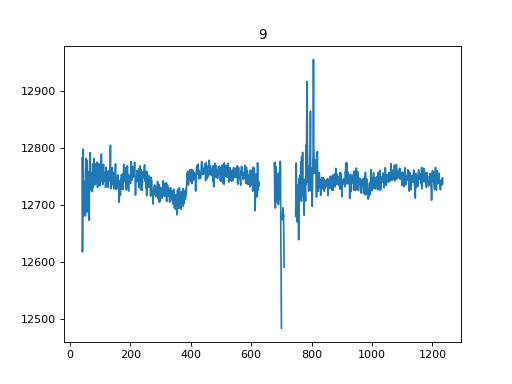

<IPython.core.display.Javascript object>


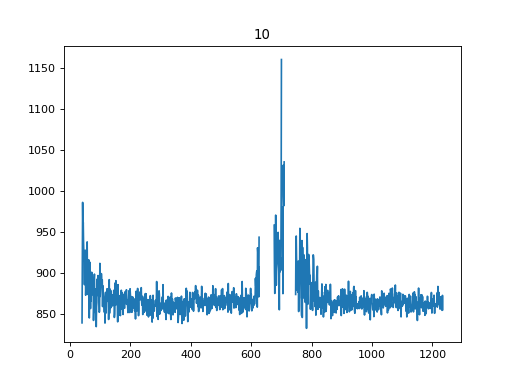

<IPython.core.display.Javascript object>


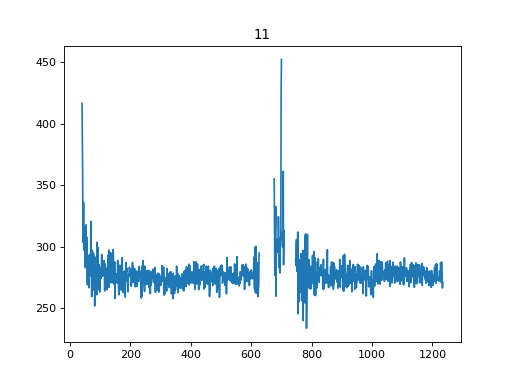

In [247]:
loc,iso,ts = Isolated_stars(pos,Tmag,mmm,median,scene,Mag=16,Distance=7)
ts = ts[flag==0]
scale = []
for i in range(len(ts)):
    #lc = np.nansum(tss[i],axis=(1,2)) 
    #lc[lc==0] = np.nan
    lc2 = np.nansum(ts[i],axis=(1,2))
    
    #lc2 = ts[i,:,3,3]
    lc2[lc2==0] = np.nan
    lc2 = lc2#/np.nanmedian(lc2)
    plt.figure()
    plt.title(i)
    plt.plot((lc2))#/np.nansum(iso[i,1]))
    #plt.plot(((lc2/np.nansum(iso[i,1]))/np.nansum(iso[i,1]))/scale[i])
    scale += [lc2]
    #scale += [1 + (lc2-np.nansum(iso[i,1]))/np.nansum(iso[i,1])]
    #plt.plot(lc-np.nansum(iso[i,1]))
scale = np.array(scale)

<IPython.core.display.Javascript object>


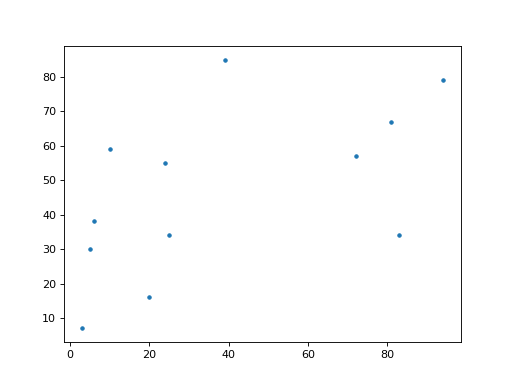

In [253]:
plt.figure()
plt.plot(loc[flag==0,1],loc[flag==0,0],'.')

<IPython.core.display.Javascript object>


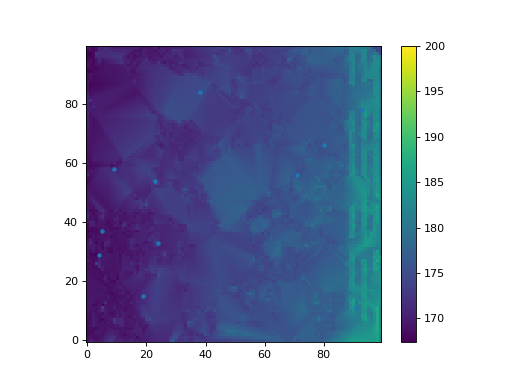

In [61]:
plt.figure()
plt.imshow(bkg[1000],origin='',vmax=200)
plt.colorbar()
plt.plot(loc[flag==0,1],loc[flag==0,0],'.')

In [273]:
mask = np.nansum(scene,axis=0)<.1

<IPython.core.display.Javascript object>


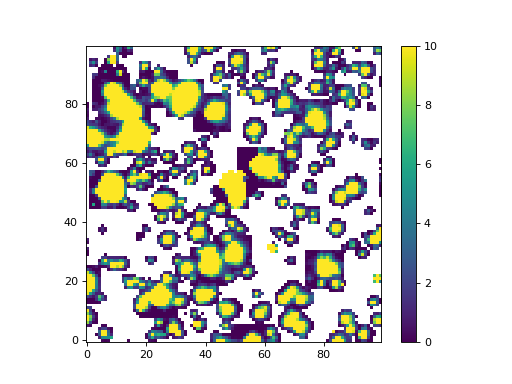

In [279]:
plt.figure()
plt.imshow(median,origin='',vmax=10)
plt.colorbar()

In [278]:
mask

array([[ True,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

/Users/ryanr/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


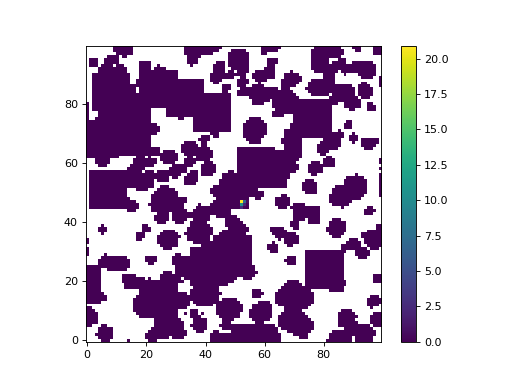

In [276]:
plt.figure()
plt.imshow(mask*median,origin='')
plt.colorbar()

<IPython.core.display.Javascript object>


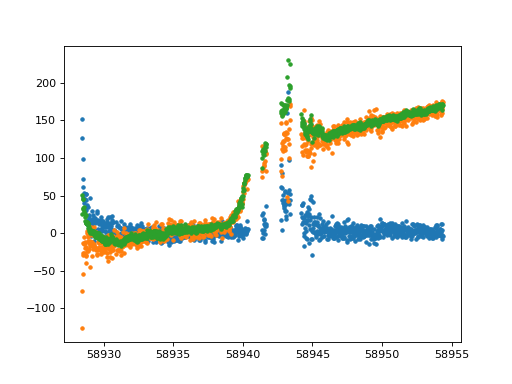

In [237]:
plt.figure()
#plt.plot(tpf.astropy_time.mjd,lc-med,'.')
plt.plot(tpf.astropy_time.mjd,ref_med,'.')
plt.plot(tpf.astropy_time.mjd,lc-med - ref_med,'.')
plt.plot(tpf.astropy_time.mjd,lc-med,'.')


/Users/ryanr/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


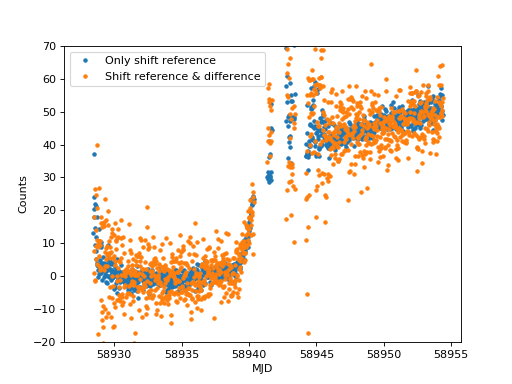

Text(0.5, 0, 'MJD')

In [119]:
plt.figure()
plt.plot(tpf.astropy_time.mjd,lc-med - ,'.',label='Motion corrected')


<IPython.core.display.Javascript object>


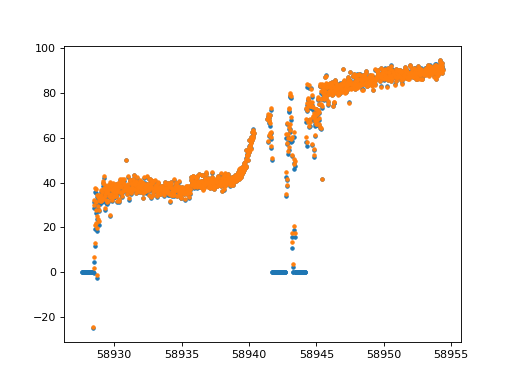

In [198]:
plt.figure()
plt.plot(tpf.astropy_time.mjd,lc,'.')
plt.plot(tpf.astropy_time.mjd,lc - 10*scale[6],'.')

In [ ]:
plt.

In [154]:
lcs = np.nansum(ts,axis=(2,3)) 
lcs[lcs==0] = np.nan
res = lcs-np.nansum(iso[:,1],axis=(1,2))[:,np.newaxis]
    

In [155]:
loc.shape

(18, 2)

In [203]:
loc.dtype

dtype('int64')

In [158]:
mask = np.zeros_like(mmm[0])
mask[loc[:,1],loc[:,0]] = 1

<IPython.core.display.Javascript object>


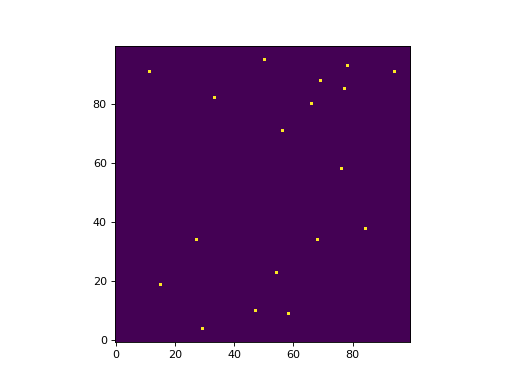

In [159]:
plt.figure()
plt.imshow(mask,origin='')

In [172]:
Guess = True
test = np.zeros_like(mmm) * np.nan
x = np.arange(0, mask.shape[1])
y = np.arange(0, mask.shape[0])
#mask invalid values
for i in range(len(mmm)):
    if np.nansum(mmm[i]) >0:
        arr = mmm[i].copy()
        arr[mask==0] = np.nan
        arr = np.ma.masked_invalid(arr)
        xx, yy = np.meshgrid(x, y)
        #get only the valid values
        x1 = xx[~arr.mask]
        y1 = yy[~arr.mask]
        newarr = arr[~arr.mask]

        estimate = sd.interpolate.griddata((x1, y1), newarr.ravel(),
                                  (xx, yy),method='linear')
        if Guess:
            estimate[np.isnan(estimate)] = np.nanmedian(estimate)
        test[i] = estimate

In [173]:
mmm

array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  

In [174]:
eh = mmm - test

<IPython.core.display.Javascript object>


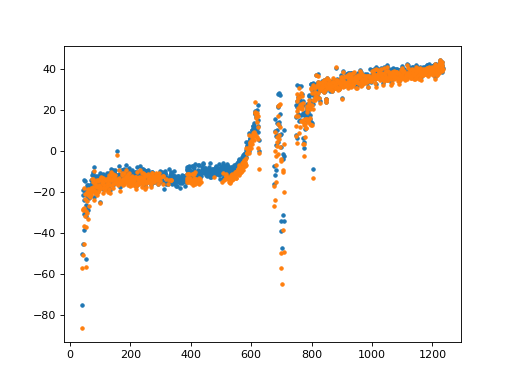

In [175]:
plt.figure()
plt.plot(mmm[:,50,50],'.')
plt.plot(eh[:,50,50],'.')

In [170]:
mmm

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [229]:
s

array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan, 

In [301]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground,SExtractorBackground

In [312]:
bkgs = []
for i in range(len(tpf.flux)):
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()
    bkg = Background2D(tpf.flux[i], (10, 10), filter_size=(3, 3),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,)
    bkgs += [bkg.background]

In [313]:
bkgs = np.array(bkgs)

In [315]:
thing = tpf.flux - bkgs 

/Users/ryanr/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


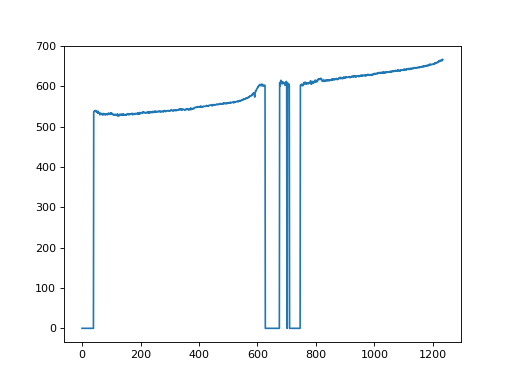

In [316]:
plt.figure()
plt.plot(thing[:,50,50])

In [309]:
bkg

<IPython.core.display.Javascript object>


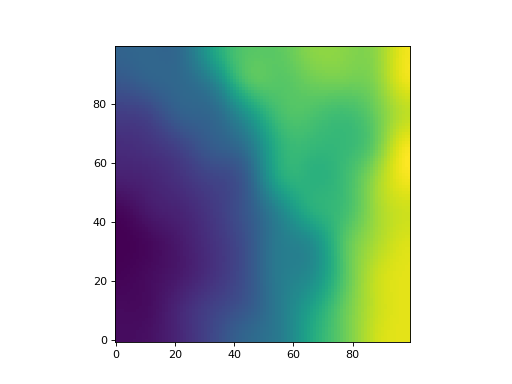

In [311]:
plt.figure()
plt.imshow(bkg.background,origin='')